In [50]:
# Importing the libraries needed

import numpy as np
import pandas as pd 
import seaborn as sb 
import matplotlib.pyplot as plt
import sklearn

from pandas import Series, DataFrame
from pylab import rcParams

from sklearn import preprocessing

In [51]:
# Importing all the modules from sklnearn to perform the analysis

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score

In [54]:
# Setting plotting paramaters

#%matplotlib inline #enables me to display the plot directly without having to call the function plt.show()
rcParams['figure.figsize'] = 5,4 #5" wide by 4" hight
sb.set_style('whitegrid')

In [56]:
# Downloading the dataset

df = pd.read_csv('titanic_data.csv')

## Exploratory Analysis of the dataset

In [57]:
print(df.info())
# There is 891 datapoints in the dataset with most values without missing values except for Age, Cabin and Embarked

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


### Variable descriptions ###

* Survived: Survival (0 = No; 1 = Yes)
* Pclass: Passenger Class (1 = 1st, 2 = 2nd, 3 = 3rd)
* Name: Name
* Sex: Sex
* Age: Age
* SibSp: Number of Siblings/Spouses Aboard
* Parch: Number of Parents/Children Aboard
* Ticket: Ticket Number
* Fare: Passenger Fare (British Pound)
* Cabin: Cabin
* Embarked: Port of Embarkation (C = Cherbourg, France; Q = Queenstown, UK; S = Southampton - Cobh, Ireland)

### Checking that my target variable is binary

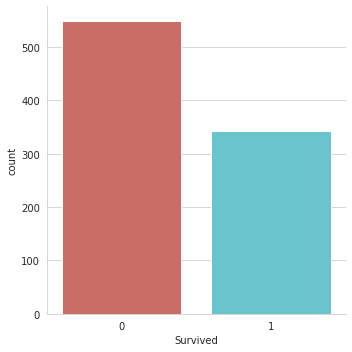

In [59]:
# Code from the original course: sb.countplot(x='Survived', data=df, palette='hls')
# I am using a more flexible code version I learned from DataCamp's "introduction to Visualization with Seaborn" course.

sb.catplot(data=df, x='Survived', kind='count', palette='hls')
plt.show()

### Checking for missing values

In [60]:
df.isnull().sum()
# There are 177 missing values in Age, 687 in Cabin and 2 in Embarked

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [61]:
df.describe()
# Displays the summary statistics of the variables

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Taking care of missing values

**Dropping missing values**

So let's just go ahead and drop all the variables that aren't relevant for predicting survival. We should at least keep the following:

* Survived: This variable is obviously relevant
* Pclass: Does a passenger's class on the boat affect their survivability?
* Sex: Could a passenger's gender impact their survival rate?
* SibSp: Does the number of relatives on the boat (that are siblings or a spouse) affect a person survivability? Probability
* Parch: Does the number of relatives on the boat (that are children or parents) affect a person survivability? Probability
* Fare: Does the fare a person paid effect his survivability? Maybe - let's keep it.
* Embarked: Does a person's point of embarkation matter? It depends on how the boat was filled... Let's keep it.

What about a pernson's name, ticket number, and passenger ID number? They're irrelevant for predicting survivability. Also, the cabin variable is almost all missing values, so we can drop all of these.

In [62]:
df2 = df.drop(columns = ['Name', 'Ticket', 'PassengerId', 'Cabin'])

In [63]:
df2.head()
# Displays the firt 5 rows of data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,male,22.0,1,0,7.2500,S
1,1,1,female,38.0,1,0,71.2833,C
2,1,3,female,26.0,0,0,7.9250,S
3,1,1,female,35.0,1,0,53.1000,S
4,0,3,male,35.0,0,0,8.0500,S


### Imputing missing values

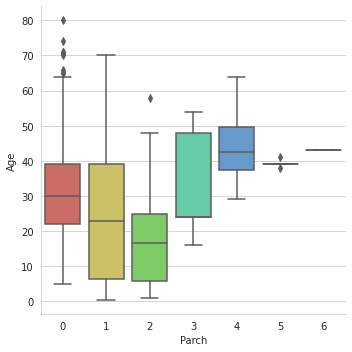

In [66]:
# Getting a quick overview of the distribution of data points for Parch vs Age.
# Simple code: sb.boxplot(x='Parch', y='Age', data=df2, palette='hls')

# Using DataCamp's taught code that provides more flexibility to play with the chart:

sb.catplot(data = df2, x = 'Parch', y = 'Age', kind ='box', palette = 'hls')
plt.show()

# The younger (Median = 20, green boxplot) the person  is the more likely they are to have at least 1 relatives on the boat (probably parents). The older the person (Median = 40, blue boxplot), the more likely that person will have 4 relatives on board (either parents or children).

The boxplot above helps us to identify we can probably fill the missing values for Age based on the number of relatives 'Parch' that person has.

Let's figure out the average age per Parch group

In [75]:
Parch_groups = df2.groupby(['Parch']).mean()
Parch_groups

,Survived,Pclass,Age,SibSp,Fare
Parch,,,,,
0,0.343658,2.321534,32.178503,0.237463,25.586774
1,0.550847,2.203390,24.422000,1.084746,46.778180
2,0.500000,2.275000,17.216912,2.062500,64.337604
3,0.600000,2.600000,33.200000,1.000000,25.951660
4,0.000000,2.500000,44.500000,0.750000,84.968750
5,0.200000,3.000000,39.200000,0.600000,32.550000
6,0.000000,3.000000,43.000000,1.000000,46.900000


In [77]:
# Writing a Function to iterate over the dataset and fill the missing values for Age based on the visual analysis above

def age_approx(cols):
    Age = cols[0]
    Parch = cols[1]

    if pd.isnull(Age):
        if Parch == 0:
            return 32
        elif Parch == 1:
            return 24
        elif Parch == 2:
            return 17
        elif Parch == 3:
            return 33
        elif Parch == 4:
            return 45
        else:
            return df2['Age'].mean()
    else:
        return Age

In [81]:
df2['Age'] = df2[['Age', 'Parch']].apply(age_approx, axis = 1)
df2.isnull().sum()

Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      2
Age_filled    0
dtype: int64